In [1]:
from IPython.display import clear_output
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
import re
import dropbox
import sys
import pandas as pd
import numpy as np
import imageio.v2 as imageio
import matplotlib.pyplot as plt
import cv2
import logging
import datetime
import glob
import json
import scipy
import matplotlib as mpl

from subprocess import call
from tifffile import imwrite
from tqdm import tqdm
from pathlib import Path
from amftrack.util.dbx import (
    upload_folder,
    download,
    read_saved_dropbox_state,
    save_dropbox_state,
    load_dbx,
    get_dropbox_folders_prince,
    get_dropbox_video_folders,
    download_video_folders_drop,
    download_analysis_folders_drop,
)
from amftrack.pipeline.launching.run import (
    run_transfer,
)
from amftrack.pipeline.launching.run_super import run_parallel_transfer
from amftrack.pipeline.launching.run_super import run_parallel_flows
from amftrack.pipeline.functions.transport_processing.high_mag_videos.plot_data import (
    plot_summary,
    save_raw_data,
)
from amftrack.pipeline.functions.transport_processing.high_mag_videos.high_mag_analysis import (
    HighmagDataset,
    VideoDataset,
    EdgeDataset,
    index_videos_dropbox_new,
    analysis_run,
)
from amftrack.pipeline.functions.transport_processing.high_mag_videos.kymo_class import (
    KymoVideoAnalysis,
    KymoEdgeAnalysis,
)
from amftrack.util.dbx import (upload
)
%load_ext autoreload
%autoreload 2
%matplotlib widget

from amftrack.pipeline.launching.run_super import (
    run_launcher,
    directory_scratch,
    directory_project,
    directory_project,
    run_parallel_stitch,
    run_parallel_transfer,
)
import os
from amftrack.pipeline.functions.image_processing.experiment_class_surf import (
    Experiment,
    save_graphs,
    load_graphs,
    Edge,
    Node,

)
from amftrack.pipeline.functions.image_processing.experiment_util import (
    get_random_edge,
    distance_point_edge,
    plot_edge,
    plot_edge_cropped,
    find_nearest_edge,
    get_edge_from_node_labels,
    plot_full_image_with_features,
    get_all_edges,
    get_all_nodes,
    find_neighboring_edges,
    reconstruct_image,
    reconstruct_skeletton_from_edges,
    reconstruct_skeletton_unicolor,
    reconstruct_image_from_general,
    plot_full,
    plot_edge_color_value,
)
from amftrack.transport.align_video_network import identify_nodes
logging.basicConfig(stream=sys.stdout, level=logging.debug)
from amftrack.util.sys import (
    get_dates_datetime,
    get_dirname,
    temp_path,
    get_data_info,
    update_plate_info,
    update_analysis_info,
    get_analysis_info,
    get_current_folders,
    get_folders_by_plate_id,
)
mpl.rcParams["figure.dpi"] = 100
from amftrack.pipeline.functions.transport_processing.high_mag_videos.loading import load_video_dataset

from amftrack.pipeline.functions.post_processing.extract_study_zone import (
    load_study_zone,
)
import networkx as nx
from amftrack.pipeline.functions.transport_processing.high_mag_videos.add_BC import *

c:\users\coren\documents\phd\code\amftrack\amftrack\util\dbx.py:3: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
directory_targ = r"C:\Users\coren\Documents\temp_441/"


plate_id = "441_20230807"

update_plate_info(directory_targ, local=True,strong_constraint=False)
all_folders = get_current_folders(directory_targ, local=True)
folders = all_folders.loc[all_folders["unique_id"] == plate_id]
folders = folders.loc[folders["/Analysis/nx_graph_pruned_labeled2.p"] == True]
folders = folders.sort_values(by="folder")

plate_id_video = "20230811_Plate441"
folders = folders.sort_values(by="datetime")

exp = Experiment(directory_targ)
# i = indexes[plate_id_video]
# i = np.where(folders['folder'] == indexes[plate_id_video])[0][0]
# selection = folders[folders['folder'].isin(indexes.values())]
i = 0
exp.load(folders.iloc[i : i + 2], suffix="_labeled2")
# exp.load(selection, suffix="_labeled")

for t in range(exp.ts):
    exp.load_tile_information(t)
    exp.save_location = ""

    load_study_zone(exp)

# load_graphs(exp, directory_targ,indexes = [0])
    edges = get_all_edges(exp, t)

    weights = {(edge.begin.label, edge.end.label): edge.length_um(t) for edge in edges}
    nx.set_edge_attributes(exp.nx_graph[t], weights, "length")
    G = exp.nx_graph[t]
    components = nx.connected_components(G)

    # Find the largest connected component
    largest_component = max(components, key=len)

    # Create a new graph representing the largest connected component
    largest_component_graph = G.subgraph(largest_component)
    exp.nx_graph[t] = largest_component_graph

analysed:   0%|          | 0/2 [00:00<?, ?it/s]

2023-08-11 16:05:00
2023-08-12 02:05:00


In [3]:
exp2 = get_exp2(exp)

Process time 1
Process time 0


c:\users\coren\documents\phd\code\amftrack\amftrack\pipeline\functions\image_processing\experiment_class_surf.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.folders["datetime"] = pd.to_datetime(


2023-08-12 02:05:00


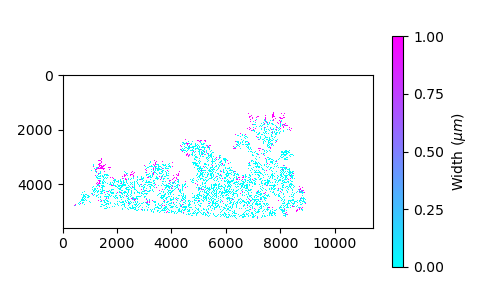

In [11]:
from matplotlib import cm

vmax = 1
vmin = 0
t=0
plot_edge_color_value(
    exp2,
    t,
    lambda edge : round(edge.get_attribute("age",t)),
    cmap=cm.get_cmap("cool", 100),
    v_min=vmin,
    v_max=vmax,
    plot_cmap=True,
    show_background=False,
    dilation=10,
    figsize=(5, 3),
    alpha = 1
)
plt.savefig(
    os.path.join("finalfigure","2", f"network_growth.pdf"),
    transparent=True,
    bbox_inches="tight",
)

In [6]:

t=0
add_betweenness_QC(exp, t)

Process time 1
Process time 0


c:\users\coren\documents\phd\code\amftrack\amftrack\pipeline\functions\image_processing\experiment_class_surf.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.folders["datetime"] = pd.to_datetime(


2023-08-12 02:05:00
tot_growth 154564.7184926793


In [11]:
##### bcs = [edge.get_attribute("betweenness_QC", t) for edge in edges]
t = 0
edges = get_all_edges(exp,t)
lengths_0 = [edge.length_um(t) for edge in edges]

t = 1
edges = get_all_edges(exp,t)
lengths_1 = [edge.length_um(t) for edge in edges]

In [88]:
np.sum(lengths_1)-np.sum(lengths_0)

-321885.6320823692

In [12]:
edges = get_all_edges(exp,0)
bcs = [edge.get_attribute("betweenness_QC", t) for edge in edges]
fig,ax = plt.subplots()
ax.hist(np.log10(np.array(bcs)+1),20)
ax.set_yscale("log")

TypeError: 'NoneType' object is not subscriptable

In [20]:
np.log10(np.max(bcs))

4.284265258540658

In [27]:
np.log10(np.max(bcs)/(2*3600)),np.log10(np.min(bcs)/(2*3600))

C:\Users\coren\AppData\Local\Temp\ipykernel_12608\904620796.py:1: RuntimeWarning: divide by zero encountered in log10
  np.log10(np.max(bcs)/(2*3600)),np.log10(np.min(bcs)/(2*3600))


(0.4269327621093896, -inf)

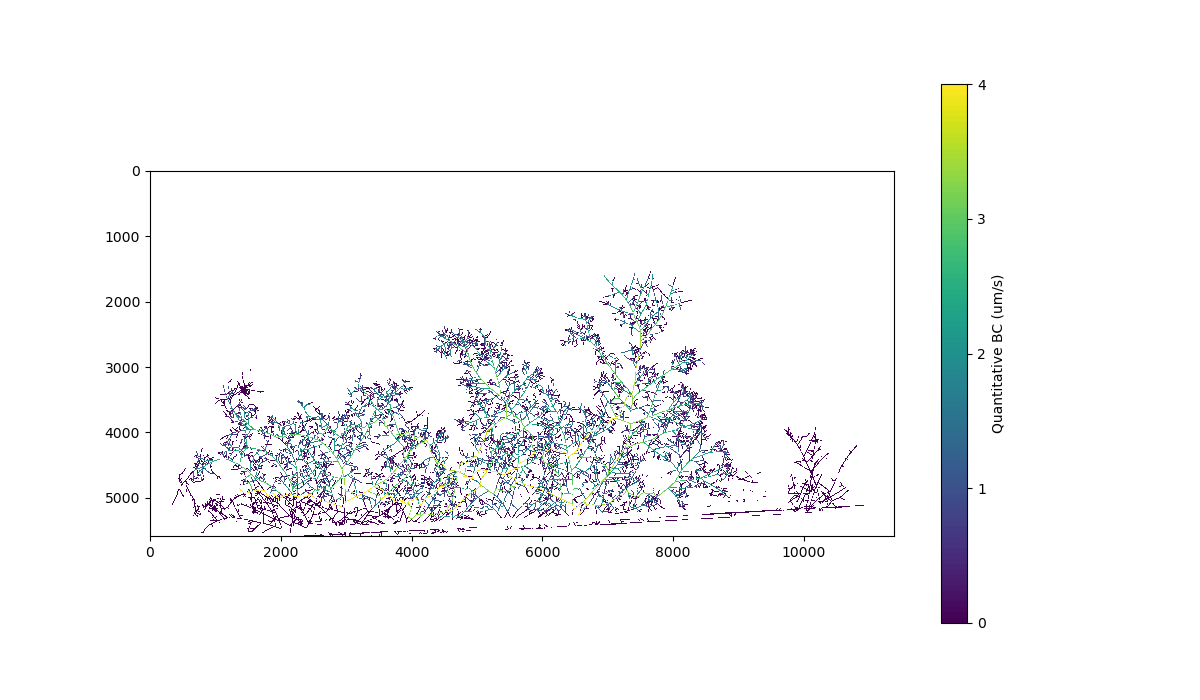

In [8]:
from matplotlib import cm

vmax = 4
vmin = 0
t=0
fig,ax = plot_edge_color_value(
    exp,
    t,
    lambda edge: np.log10(edge.get_attribute("betweenness_QC", t)+1),
    # lambda edge : 2,
    cmap=cm.get_cmap("viridis", 100),
    v_min=vmin,
    v_max=vmax,
    plot_cmap=True,
    show_background=False,
    dilation=10,
    figsize=(12, 7),
    alpha = 1,
    save_path = "figfull",
    dpi = 400,
    label_colorbar = "Quantitative BC (um/s)"
)

In [18]:
G = exp.nx_graph[0]
paths = dict(nx.all_pairs_shortest_path(G, cutoff=None))


KeyboardInterrupt



In [23]:
t = 0
fun = lambda edge: edge.get_attribute("betweenness_QC", t)
BC_dev = lambda edge: get_derivative(edge, t, fun)

In [24]:
from amftrack.pipeline.functions.transport_processing.high_mag_videos.add_BC import (
    get_abcisse,
    add_betweenness,
    add_hyphal_attributes,
    add_betweenness_QP,
    get_derivative, add_betweenness_QC,
)
direction = {}
for edge in exp.nx_graph[t].edges:
    direction[edge] = BC_dev(Edge(Node(edge[0],exp),Node(edge[1],exp),exp))
nx.set_edge_attributes(exp.nx_graph[t], direction, "direction_flux")


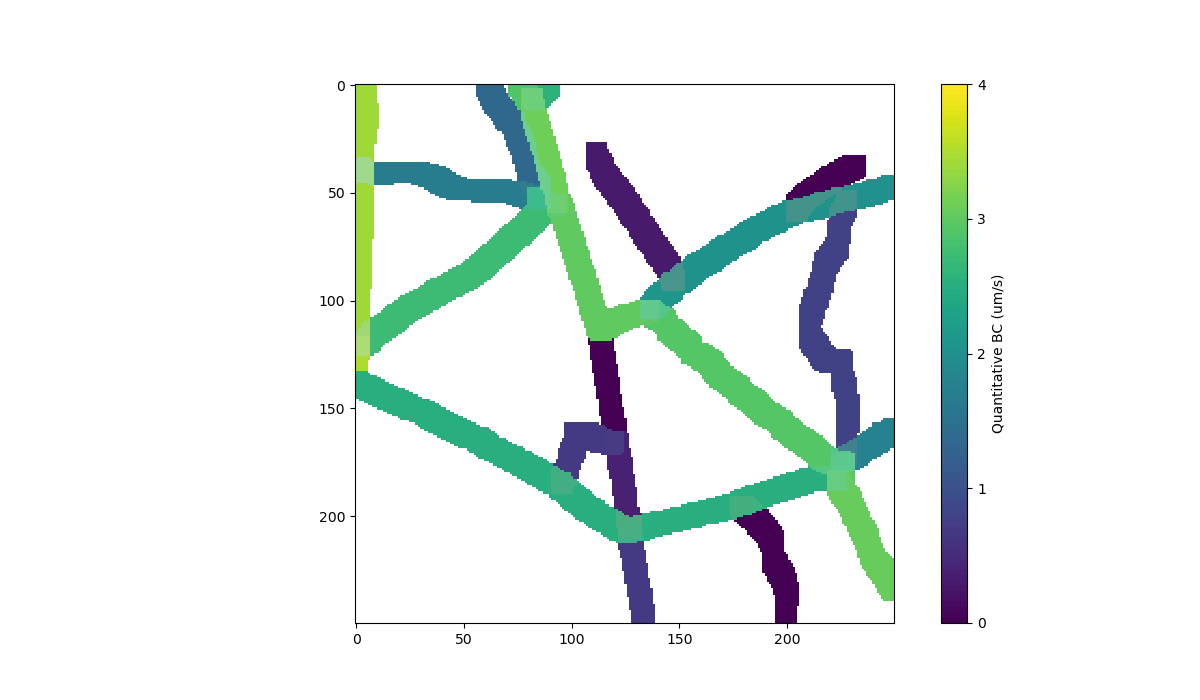

In [41]:
from matplotlib import cm
from amftrack.pipeline.functions.transport_processing.high_mag_videos.plotting import *

vmax = 4
vmin = 0
t=0
downsizing = 5
edges_network = get_all_edges(exp,t)
region = [[3650*downsizing,5450*downsizing],[3900*downsizing,5700*downsizing]]
fig, ax,f = plot_edge_color_value_2(
    exp,
    t,
    lambda edge: np.log10(edge.get_attribute("betweenness_QC", t)+1),
    # lambda edge : 2,
    cmap=cm.get_cmap("viridis", 100),
    v_min=vmin,
    v_max=vmax,
    plot_cmap=True,
    show_background=False,
    dilation=10,
    figsize=(12, 7),
    alpha = 1,
    save_path = "figfull",
    dpi = 400,
    label_colorbar = "Quantitative BC (um/s)",
    region = region
)
for edge in edges_network:
    pixels = edge.pixel_list(t)
    if len(pixels)>20:
        center_arrow = f(pixels[len(pixels) // 2])

        begin_arrow = f(pixels[10])
        end_arrow = f(pixels[-10])
        # begin_arrow = edges_network[0].begin.pos(t)
        # end_arrow = edges_network[0].pixel_list(t)[10]
        vector = end_arrow - begin_arrow
        flux_direction = edge.get_attribute("direction_flux", t)
        flux = edge.get_attribute("betweenness_QC", t)
        if flux>1000:
            vector = (
                vector / np.linalg.norm(vector) * 100 / downsizing * (1 - 2 * (flux_direction > 0))
            )
            ax.arrow(center_arrow[1], center_arrow[0], vector[1], vector[0], width=10)

In [15]:
nodes_source,nodes_exp = get_nodes_source_C(exp)
nodes_sink = [node for node in nodes if is_in_ROI_node(node, t)]
nodes_sink = find_lowest_nodes(nodes_sink, t)

Process time 1
Process time 0


c:\users\coren\documents\phd\code\amftrack\amftrack\pipeline\functions\image_processing\experiment_class_surf.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.folders["datetime"] = pd.to_datetime(


2023-08-12 02:05:00
tot_growth 30846.28134458463


NameError: name 'nodes' is not defined

In [16]:
last_index = 1
segments_length = 5

final_graph = exp.nx_graph[last_index].copy()
node_not_in_ROI = []
for node in final_graph:
    if not is_in_ROI_node(Node(node, exp), last_index):
        node_not_in_ROI.append(node)
final_graph.remove_nodes_from(node_not_in_ROI)

label = max(final_graph.nodes) + 1
graph_segemented_final = nx.empty_graph()
nodes_pos = {}
edges_indexes = {}
segments_index = {}
segments_center_final = []

for edge in final_graph.edges:
    e = Edge(Node(edge[0], exp), Node(edge[1], exp), exp)
    edges_indexes[f"{edge[0]},{edge[1]}"] = []
    pixels = e.pixel_list(last_index)
    length = len(pixels)
    if length < segments_length:
        graph_segemented_final.add_edge(edge[0], edge[1])
        segments_index[f"{edge[0]},{edge[1]}"] = len(segments_center_final)
        edges_indexes[f"{edge[0]},{edge[1]}"].append(len(segments_center_final))
        central_point = np.mean(np.array(pixels), axis=0)
        segments_center_final.append(central_point)
        nodes_pos[edge[0]] = pixels[0]
        nodes_pos[edge[1]] = pixels[-1]
        continue

    for i in range(0, length, segments_length):
        sub_list = pixels[i:i+segments_length]
        if i==0:
            graph_segemented_final.add_edge(edge[0], label)
            segments_index[f"{edge[0]},{label}"] = len(segments_center_final)
            edges_indexes[f"{edge[0]},{edge[1]}"].append(len(segments_center_final))
            central_point = np.mean(np.array(sub_list), axis=0)
            segments_center_final.append(central_point)
            nodes_pos[edge[0]] = sub_list[0]
            nodes_pos[label] = sub_list[-1]
            label += 1
        elif i+segments_length >= length:
            graph_segemented_final.add_edge(label-1, edge[1])
            segments_index[f"{label-1},{edge[1]}"] = len(segments_center_final)
            edges_indexes[f"{edge[0]},{edge[1]}"].append(len(segments_center_final))
            central_point = np.mean(np.array(sub_list), axis=0)
            segments_center_final.append(central_point)
            nodes_pos[edge[1]] = sub_list[-1]
        else:
            graph_segemented_final.add_edge(label-1, label)
            segments_index[f"{label-1},{label}"] = len(segments_center_final)
            edges_indexes[f"{edge[0]},{edge[1]}"].append(len(segments_center_final))
            central_point = np.mean(np.array(sub_list), axis=0)
            segments_center_final.append(central_point)
            nodes_pos[label] = sub_list[-1]
            label += 1

print(f"amount of nodes: {graph_segemented_final.number_of_nodes()}")
print(f"amount of segments: {graph_segemented_final.number_of_edges()}")

array_segments_center_final = np.array(segments_center_final)
shape_segments_center = array_segments_center_final.shape
print(f"Shape array_segments_center_final: {shape_segments_center}")

amount of nodes: 463184
amount of segments: 465836
Shape array_segments_center_final: (465836, 2)


In [17]:
def closest_point(point, points):
    dist_square = np.sum((points-point)**2, axis=1)
    min_index = np.argmin(dist_square)
    return points[min_index], dist_square[min_index]

In [19]:
# When there is a point at a distance of segment under the threshold, the segment is activated (distance in pixel)
# A good distance is (2*segments_length)**2
# Don't forget to square because closest_point give the distance squared
threshold = 10**2

segments_centers = []
segments_min_distances = []
array_segments_center = array_segments_center_final.copy()
for time in reversed(range(last_index+1)):
    print(f"Process time {time}")
    rows = []
    cols = []
    previous_edges = get_all_edges(exp, time)
    for edge in previous_edges:
        p_list = [(round(pixel[0]),round(pixel[1])) for pixel in edge.pixel_list(time)]
        row, col = zip(*p_list)
        rows.extend(row)
        cols.extend(col)
    
    data = np.ones(len(rows))
    points_matrix = sparse.csr_matrix((data, (rows, cols)))
    
    centers_distance = []
    new_centers = array_segments_center.copy()
    for index, center in enumerate(array_segments_center):
        xc, yc = center
        xc, yc = int(xc), int(yc)

        min_x, max_x = max(0, xc-4*segments_length), xc+4*segments_length
        min_y, max_y = max(0, yc-4*segments_length), yc+4*segments_length
        coords = points_matrix[min_x:max_x, min_y:max_y].nonzero()
        coords = np.column_stack(coords)
        if not coords.shape[0]:
            centers_distance.append(32*(segments_length**2))
            continue

        xc -= min_x
        yc -= min_y

        new_center, min_dist = closest_point([xc, yc], coords)
        centers_distance.append(min_dist)
        if min_dist < threshold:
            new_centers[index] = new_center + np.array([min_x, min_y])
    
    array_segments_center = new_centers
    segments_centers.append(new_centers)
    segments_min_distances.append(centers_distance)

segments_min_distances.reverse()
# Index t are the centers of the segments at time t
segments_centers.reverse()

Process time 1
Process time 0


In [20]:
# Amount of segment to look for at in an edge to get the date at which the edge encounter the node
# Depends of how big segments are and what threshold you use
amount_of_border_segment = 7

segments_min_distances_array = np.array(segments_min_distances)
segments_min_distances_array = np.where(segments_min_distances_array<threshold, 1, 0)
segments_time = segments_min_distances_array.argmax(axis=0)

edges_time_interval = {}

for e in final_graph.edges:
    edge = Edge(Node(e[0], exp), Node(e[1], exp), exp)
    segments_indexes = edges_indexes[f"{edge.begin.label},{edge.end.label}"]
    segments_times = np.array([segments_time[index] for index in segments_indexes])

    begin = np.median(segments_times[:amount_of_border_segment])
    if len(segments_times)>amount_of_border_segment:
        end = np.median(segments_times[-amount_of_border_segment:])
    else:
        end = np.median(segments_times)

    edges_time_interval[f"{edge.begin.label},{edge.end.label}"] = (begin, end)

In [ ]:
plt.close("all")
fig, ax1 = plt.subplots(1, 1, figsize=(14, 8)) 

for key, edge in enumerate(graph_segemented_final.edges):
    begin, end = edge
    (y1, x1), (y2, x2) = nodes_pos[begin], nodes_pos[end]
    index = segments_index.get(f"{begin},{end}")
    if index is None:
        index = segments_index[f"{end},{begin}"]
    time = segments_time[index]
    color = cm.viridis(time/last_index)
    if time < 100:
    
        ax1.plot([x1, x2], [y1, y2], c=color)

sm = plt.cm.ScalarMappable(cmap=cm.viridis) 
sm.set_array([]) 
plt.colorbar(sm, ax=ax1) 

plt.xlim(0, 56000)
plt.ylim(0, 30000)
plt.gca().invert_yaxis()

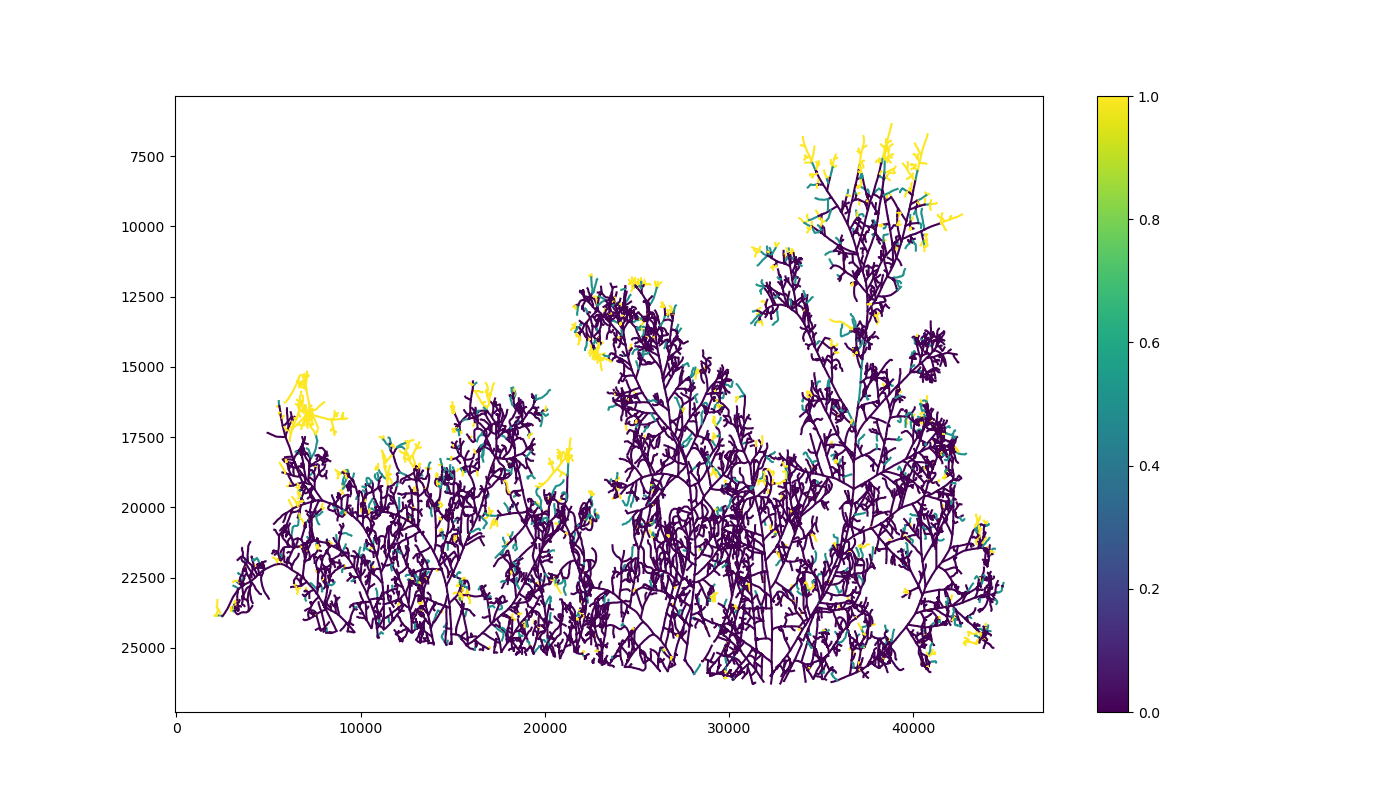

In [21]:
plt.close("all")
fig, ax1 = plt.subplots(1, 1, figsize=(14, 8))

for e in final_graph.edges:
    edge = Edge(Node(e[0], exp), Node(e[1], exp), exp)
    time_interval = edges_time_interval.get(f"{edge.begin.label},{edge.end.label}")
    time = (time_interval[0]+time_interval[1])/2 # type: ignore
    pixels = edge.pixel_list(last_index)
    y, x = zip(*pixels)
    color = cm.viridis(time/last_index)
    plt.plot(x, y, color=color)

sm = plt.cm.ScalarMappable(cmap=cm.viridis)
sm.set_array([]) 
plt.colorbar(sm, ax=ax1) 

plt.gca().invert_yaxis()

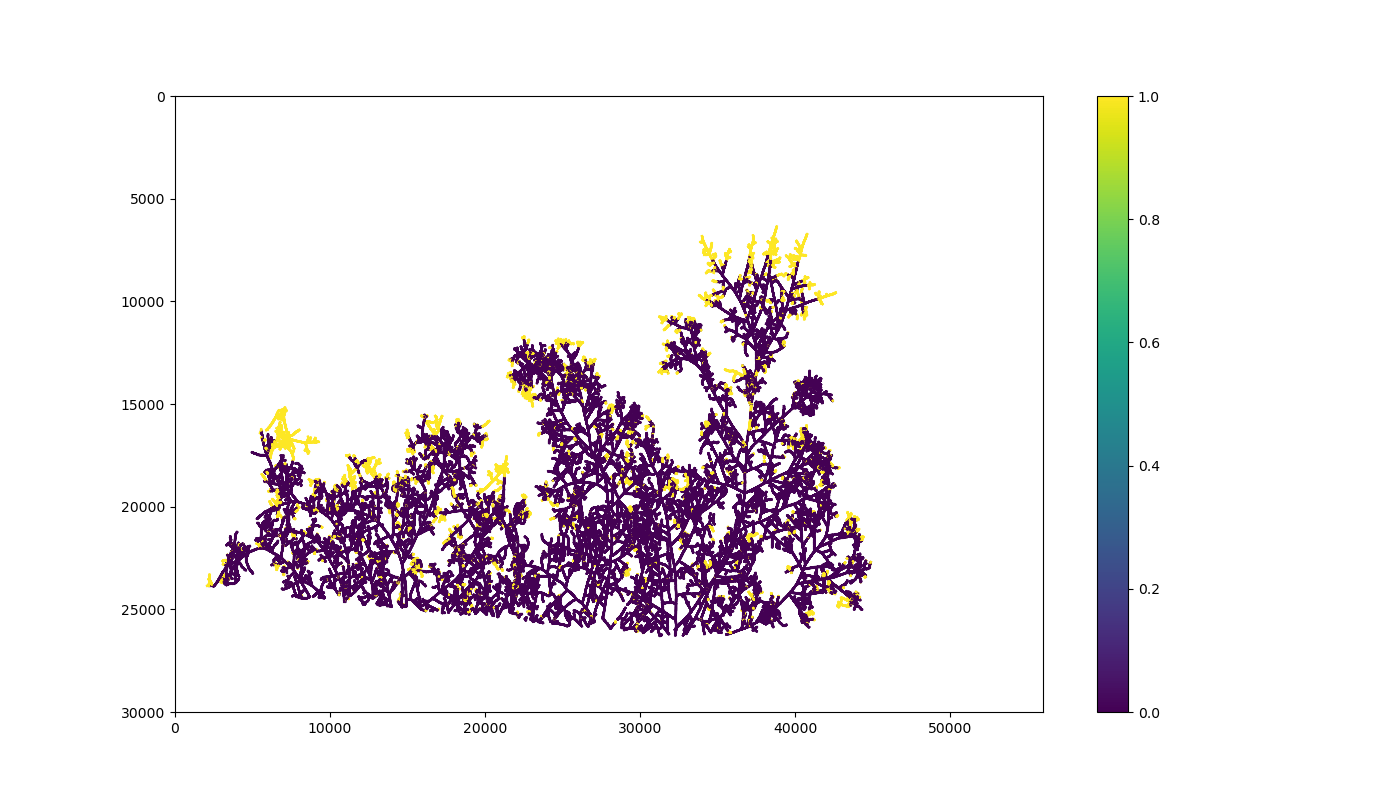

In [23]:
plt.close("all")
fig, ax1 = plt.subplots(1, 1, figsize=(14, 8)) 

for key, edge in enumerate(graph_segemented_final.edges):
    begin, end = edge
    (y1, x1), (y2, x2) = nodes_pos[begin], nodes_pos[end]
    index = segments_index.get(f"{begin},{end}")
    if index is None:
        index = segments_index[f"{end},{begin}"]
    time = segments_time[index]
    color = cm.viridis(time/last_index)
    if time < 100:
    
        ax1.plot([x1, x2], [y1, y2], c=color)

sm = plt.cm.ScalarMappable(cmap=cm.viridis) 
sm.set_array([]) 
plt.colorbar(sm, ax=ax1) 

plt.xlim(0, 56000)
plt.ylim(0, 30000)
plt.gca().invert_yaxis()

In [35]:
exp2.load(exp.folders.iloc[1: 2], suffix="_labeled2")
exp2.nx_graph = [graph_segemented_final]
exp2.positions = [nodes_pos]
pixel_lists = {}
lengths = {}

t = 0
for key, edge in enumerate(graph_segemented_final.edges):
    begin, end = edge
    (y1, x1), (y2, x2) = nodes_pos[begin], nodes_pos[end]
    pixel_lists[edge] = [(y1, x1), (y2, x2)]
    pixel_conversion_factor = 1.725
    lengths[edge] = np.sqrt((y1-y2)**2+(x1-x2)**2)*pixel_conversion_factor

nx.set_edge_attributes(exp2.nx_graph[t], pixel_lists, "pixel_list")
edges = get_all_edges(exp2, 0)
ages = {(edge.begin.label, edge.end.label): get_age(edge) for edge in edges}
nx.set_edge_attributes(exp2.nx_graph[t], ages, "age")
nx.set_edge_attributes(exp2.nx_graph[t], lengths, "length")

c:\users\coren\documents\phd\code\amftrack\amftrack\pipeline\functions\image_processing\experiment_class_surf.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.folders["datetime"] = pd.to_datetime(


2023-08-12 02:05:00


In [34]:
def get_age(edge):
    begin,end = edge.begin.label,edge.end.label
    index = segments_index.get(f"{begin},{end}")
    if index is None:
        index = segments_index[f"{end},{begin}"]
    time = segments_time[index]
    return(time)

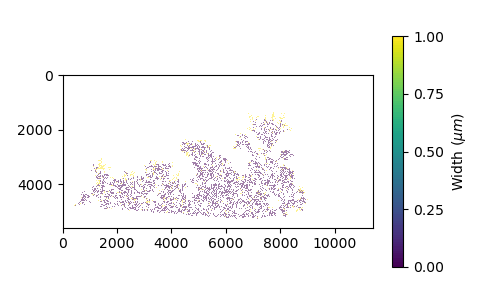

(<Figure size 500x300 with 2 Axes>, <AxesSubplot: >)

In [36]:
from matplotlib import cm

vmax = 1
vmin = 0
t=0
plot_edge_color_value(
    exp2,
    t,
    lambda edge : edge.get_attribute("age",t),
    cmap=cm.get_cmap("viridis", 100),
    v_min=vmin,
    v_max=vmax,
    plot_cmap=True,
    show_background=False,
    dilation=10,
    figsize=(5, 3),
)